$
\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\mf}{{\bf F}}
\newcommand{\vu}{{\bf u}}
\newcommand{\vx}{{\bf x}}
\newcommand{\vy}{{\bf y}}
\newcommand{\vs}{{\bf s}}
\newcommand{\ve}{{\bf e}}
\newcommand{\vd}{{\bf d}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ml}{{\bf L}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mv}{{\bf V}}
\newcommand{\ma}{{\bf A}}
\newcommand{\mi}{{\bf I}}
\newcommand{\mm}{{\bf M}}
\newcommand{\ball}{{\cal B}}
\newcommand{\ptc}{{\Psi TC}}
\newcommand{\diag}{\mbox{diag}}
$

In [1]:
include("fanote_init.jl")

## Section 2.8 Solvers for Chapter 2

Contents for Section 2.8

[Overview](#Overview)

- [nsol.jl](#Section-2.8.1:-nsol.jl)

- [H-equation Revisited](#Section-2.8.2:-H-Equation-revisited)

- [More on the Two-Point BVP](#Section-2.8.3:-More-on-the-Two-Point-BVP)

- [Shamanskii for the Convection-Diffusion Problem](#Section-2.8.4:-Shamanskii-for-the-Convection-Diffusion-Problem)

- [ptcsol.jl](#Section-2.8.5:-ptcsol.jl)

- [More on the Buckling Beam](#More-on-the-Buckling-Beam)

- [Section 2.9: Projects](#Section-2.9:-Projects)


### Overview

We will follow the pattern of Chapter 1 and present two solvers, a Newton code and a $\ptc$ code. Both codes are for systems of equations and use direct methods to compute the step. We returned the solution history for the simple two dimensional example in Section 2.6, but will not do that again.

### Section 2.8.1: nsol.jl

__nsol.jl__ solves systems of nonlinear equations and computes the Newton step with direct linear solvers. Let's look at the docstrings.

In [2]:
?nsol

search: nsol nsoli nsolsc aasol nsolheq Bool cool ptcsol nor htol ishold ntoh



```
nsol(F!, x0, FS, FPS, J!=diffjac!; rtol=1.e-6, atol=1.e-12,
           maxit=20, solver="newton", sham=5, armmax=10, resdec=.1,
           dx = 1.e-7, armfix=false, 
           pdata = nothing, jfact = klfact,
           printerr = true, keepsolhist = false, stagnationok=false)
```

C. T. Kelley, 2022

Julia versions of the nonlinear solvers from my SIAM books.  Herewith: nsol

You must allocate storage for the function and Jacobian in advance –> in the calling program <– ie. in FS and FPS

Inputs:

  * F!: function evaluation, the ! indicates that F! overwrites FS, your   preallocated storage for the function.

    So FS=F!(FS,x) or FS=F!(FS,x,pdata) returns FS=F(x)

    Your function MUST have –> return FS <– at the end.   See the examples in the docstrings and in TestProblems/Systems/simple.jl
  * x0: initial iterate

  * FS: Preallocated storage for function. It is a vector of size N

    You should store it as (N) and design F! to use vectors of size (N).  If you use (N,1) consistently instead, the solvers may work, but I make no guarantees.
  * FPS: preallocated storage for Jacobian. It is an N x N matrix

  * J!: Jacobian evaluation, the ! indicates that J! overwrites FPS, your   preallocated storage for the Jacobian. If you leave this out the   default is a finite difference Jacobian.

    So, FP=J!(FP,FS,x) or FP=J!(FP,FS,x,pdata) returns FP=F'(x). 

    (FP,FS, x) must be the argument list, even if FP does not need FS.   One reason for this is that the finite-difference Jacobian   does and that is the default in the solver.

    Your Jacobian function MUST have –> return FP <– at the end.   See the examples in the docstrings and in TestProblems/Systems/simple.jl

  * Precision: Lemme tell ya 'bout precision. I designed this code for    full precision functions and linear algebra in any precision you want.    You can declare   FPS as Float64, Float32, or Float16 and nsol will do the right thing if   YOU do not destroy the declaration in your J! function. I'm amazed   that this works so easily. If the Jacobian is reasonably well    conditioned, you can cut the cost of Jacobian factorization and   storage in half with no loss. For large dense Jacobians and inexpensive   functions, this is a good deal.

    BUT ... There is very limited support for direct sparse solvers in   anything other than Float64. I recommend that you only use Float64   with direct sparse solvers unless you really know what you're doing. I   have a couple examples in the notebook, but watch out.

---

Keyword Arguments (kwargs):

rtol and atol: relative and absolute error tolerances

maxit: limit on nonlinear iterations

solver: default = "newton"

Your choices are "newton" or "chord". However, you have sham at your disposal only if you chose newton. "chord" will keep using the initial derivative until the iterate converges, uses the iteration budget, or the line search fails. It is not the same as sham=Inf, which is smarter.

sham: default = 5 (ie Newton)

This is the Shamanskii method. If sham=1, you have Newton. The iteration updates the derivative every sham iterations. The convergence rate has local q-order sham+1 if you only count iterations where you update the derivative. You need not provide your own derivative function to use this option. sham=Inf is chord only if chord is converging well.

I made sham=1 the default for scalar equations. For systems I'm more aggressive and want to invest as little energy in linear algebra as possible. So the default is sham=5.

armmax: upper bound on step size reductions in line search

resdec: default = .1

This is the target value for residual reduction. The default value is .1. In the old MATLAB codes it was .5. I only turn Shamanskii on if the residuals are decreasing rapidly, at least a factor of resdec, and the line search is quiescent. If you want to eliminate resdec from the method ( you don't ) then set resdec = 1.0 and you will never hear from it again.

dx: default = 1.e-7

difference increment in finite-difference derivatives       h=dx*norm(x,Inf)+1.e-8

armfix: default = false

The default is a parabolic line search (ie false). Set to true and the step size will be fixed at .5. Don't do this unless you are doing experiments for research.

pdata:

precomputed data for the function/Jacobian.  Things will go better if you use this rather than hide the data  in global variables within the module for your function/Jacobian

If you use pdata in either of F! or J!, you must use in in the  calling sequence of both.

jfact: default = klfact (tries to figure out best choice) 

If your Jacobian has any special structure, please set jfact to the correct choice for a factorization.

I use jfact when I call PrepareJac! to evaluate the Jacobian (using your J!) and factor it. The default is to use klfact (an internal function) to do something reasonable. For general dense matrices, klfact picks lu! to compute an LU factorization and share storage with the Jacobian.  You may change LU to something else by, for example, setting jfact = cholesky! if your Jacobian is spd.

klfact knows about banded matrices and picks qr. You should, however RTFM, allocate the extra two upper bands, and use jfact=qr! to override klfact.

klfact uses lu for general sparse matrices.

If you give me something that klfact does not know how to dispatch on, then nothing happens. I just return the original Jacobian matrix and  nsol will use backslash to compute the Newton step. I know that this is probably not optimal in your situation, so it is  good to pick something else, like jfact = lu.

If you want to manage your own factorization within your Jacobian  evaluation function, then set

jfact = nofact

and nsol will not attempt to factor your Jacobian. That is also what happens when klfact does not know what to do. Your Jacobian is sent directly to Julia's \  operation

Please do not mess with the line that calls PrepareJac!. 

```
    FPF = PrepareJac!(FPS, FS, x, ItRules)
```

FPF is not the same as FPS (the storage you allocate for the Jacobian) for a reason. FPF and FPS do not have the same type, even though they share storage. So, FPS=PrepareJac!(FPS, FS, ...) will break things.

printerr: default = true

I print a helpful message when the solver fails. To suppress that message set printerr to false.

keepsolhist: default = false

Set this to true to get the history of the iteration in the output tuple. This is on by default for scalar equations and off for systems. Only turn it on if you have use for the data, which can get REALLY LARGE.

stagnationok: default = false

Set this to true if you want to disable the line search and either observe divergence or stagnation. This is only useful for research or writing a book.

Output:

  * A named tuple (solution, functionval, history, stats, idid,              errcode, solhist)

where

– solution = converged result

– functionval = F(solution)

– history = the vector of residual norms (||F(x)||) for the iteration

– stats = named tuple of the history of (ifun, ijac, iarm), the number of functions/derivatives/steplength reductions at each iteration.

I do not count the function values for a finite-difference derivative because they count toward a Jacobian evaluation. 

– idid=true if the iteration succeeded and false if not.

– errcode = 0 if the iteration succeeded

```
    = -1 if the initial iterate satisfies the termination criteria

    = 10 if no convergence after maxit iterations

    = 1  if the line search failed
```

– solhist:

This is the entire history of the iteration if you've set keepsolhist=true

solhist is an N x K array where N is the length of x and K is the number of iterations + 1. So, for scalar equations, it's a row vector.

---

### Examples for nsol

#### World's easiest problem example.

Test 64 and 32 bit Jacobians. No meaningful difference in the residual histories or the converged solutions.

```jldoctest
 julia> function f!(fv,x)
       fv[1]=x[1] + sin(x[2])
       fv[2]=cos(x[1]+x[2])
#
# The return fv part is important even though f! overwrites fv.
#
       return fv
       end
f (generic function with 1 method)

julia> x=ones(2); fv=zeros(2); jv=zeros(2,2); jv32=zeros(Float32,2,2);
julia> nout=nsol(f!,x,fv,jv; sham=1);
julia> nout32=nsol(f!,x,fv,jv32; sham=1);
julia> [nout.history nout32.history]
5×2 Matrix{Float64}:
 1.88791e+00  1.88791e+00
 2.43119e-01  2.43120e-01
 1.19231e-02  1.19231e-02
 1.03266e-05  1.03265e-05
 1.46388e-11  1.45995e-11

julia> [nout.solution nout.solution-nout32.solution]
2×2 Array{Float64,2}:
 -7.39085e-01  -5.48450e-14
  2.30988e+00  -2.26485e-14
```

#### H-equation example.

I'm taking the sham=5 default here, so the convergence is not quadratic. The good news is that we evaluate the Jacobian only once.

```jldoctest
julia> n=16; x0=ones(n); FV=ones(n); JV=ones(n,n);
julia> hdata=heqinit(x0, .5);
julia> hout=nsol(heqf!,x0,FV,JV;pdata=hdata);
julia> hout.history
4-element Array{Float64,1}:
 6.17376e-01
 3.17810e-03
 2.75227e-05
 2.35817e-07
```


#### Input

The calling sequence for the Newton solvers in this book are similar, differing mostly in the management of the linear solver and memory allocation. The calling sequence for __nsol.jl__ is

```julia
function nsol(
    F!,
    x0,
    FS,
    FPS,
    J! = diffjac!;
    rtol = 1.e-6,
    atol = 1.e-12,
    maxit = 20,
    solver = "newton",
    sham = 1,
    armmax = 10,
    resdec = 0.1,
    dx = 1.e-7,
    armfix = false,
    pdata = nothing,
    jfact = lu!,
    printerr = true,
    keepsolhist = false,
    stagnationok = false,
)
```

As we said earlier in the chapter, the calling sequence has some new things which are not in __nsolsc.jl__. The most significant are the arrays __FS__ and __FPS__, which preallocate
storage for the function and Jacobian. As we have pointed out earlier, the farther upstream one allocates memory the better, so __nsol.jl__ insists that you allocate an vector __FS__ of the same size as the initial iterate and a matrix 
__FPS__ for the Jacobian. 

For problems in several variables, the keyword argument __pdata__ is very important. This is the data structure for you to store any precomputed or preallocated data your function evaluation needs. You will almost surely need __pdata__ for any but the most trivial problems. Most of the examples from in this chapter use __pdata__ in a serious manner.

You should dimension __x0__ either as $(N)$ (or equivalently $(N,)$) and dimension __FS__ the same way. __nsol.jl__ expects vectors to be in double precision (Float64). Unless you are porting old code you should
dimension $\vx$ and $\mf$ as vectors $(N)$ not as two dimensional arrays with one column $(N,1)$. The solvers 
should handle both, but I cannot guarantee that.

The __!__ in the function evaluation __F!__ is to indicate that __nsold__ expects __F__  to overwrite its input. So,
the way to call __F!__ is to preallocate the storage for the function value in an array __FS__ and then call the function as
```Julia
F!(FS,x)
```
or
```Julia
F!(FS,x,pdata)
```
__nsol.jl__ will figure out if you have populated __pdata__ or left it alone as the default value of __nothing__.


And now for the Jacobian. __nsol.jl__ uses direct methods for linear algebra. If your matrix is dense, the default is to use Julia's __lu!__ function to do an LU factorization. If your matrix is symmetric or symmetric positive definite you can use the __jfact__ keyword to change __lu!__ to __ldlt!__ or __cholesky!__ for example. __nsold.jl__ assumes that the factorization you ask for will overwrite the matrix. Hence, the __factorize__ function in Julia is not what you want for this application.

If the Jacobian is sparse, __nsol.jl__ will use __lu__ instead of __lu!__. The reason
for this is that one cannot overwrite the Jacobian with the factorization
in the general sparse case.

You will also need to preallocate storage for the Jacobian in the array __FPS__. You may use any legal real precision for __FPS__. Float64 is the default. If you use Float32 you cut the storage for the matrix and the time for the factorization in half. We recommend that you do this if your Jacobian is dense. If you are using the __Sparsesuite__ sparse solvers, then you must store the Jacobian in double precision. __Sparsesuite__ does not support lower precision.

Your Jacobian computation __J!__ must also overwrite it's input. The call looks like
```julia
J!(FV,FP,x)
```
or 
```julia
J!(FV,FP,x,pdata)

```
returns FP=F'(x). The input FP=F(x), which __nsol.jl__ has already computed, has to be there. 


## Section 2.8.2: H-Equation revisited

In this section we do several experiments to illustrate the advantages of infrequent evaluation and factorization of the Jacobian and mixed precision computation. We will begin with a function that will support our testing. We want to investigate combinations of Newton's method/Shamanskii with ```sham=5``` (the default), storing and factoring the Jacobian in double/single precision, and analytic/forward difference Jacobians. To make this easy we write a function that solves the H-equation with __nsol.jl__ and lets us vary these cases. 

The functions for the residual __heqf!.jl__, the Jacobian __heqJ!.jl__, and the precomputed data 
__heqinit.jl__ are in the large file 
[src/TestProblems/Systems/Hequation.jl](https://github.com/ctkelley/SIAMFANLEquations.jl/blob/master/src/TestProblems/Systems/Hequation.jl).


I'm passing the precomputed data to the function rather than computing it within. This keeps the cost of the precomputed data out of the benchmarking I'll do later.

We use __splat__ in this example. We populate a named tuple ```bargs``` to keep the keyword arguments in a convenient place and then, when it's time to give it to __nsol.jl__, the call looks like ```bargs...```. The three dots are the __splat__ and tell __nsol__ to expand bargs and harvest the keyword arguments. 

In [3]:
function htest(x0, FS, FPS, hdata; analytic=false, hsham=5)
    n=length(FS)
    #
    # I've preallocaed x0, FS, and FPS. But they may have 
    # been changed by previous runs.
    # The cost of resetting their entries to 1.0 is insignificant. 
    #
    FS.=1.0
    FPS.=1.0
    bargs=(atol = 1.e-10, rtol = 1.e-10, sham = hsham, 
        resdec = .1, pdata=hdata)
    if analytic
        nout=nsol( heqf!, x0, FS, FPS, heqJ!; bargs...)
    else
        nout=nsol( heqf!, x0, FS, FPS; bargs...)
    end
    return nout
end

htest (generic function with 1 method)

To begin we will compare the iteration histories for four cases. We will consider analytic and forward difference Jacobians with the storage and factorization of the Jacobian done in double and single precision. __Theorem 1.2__ says the results should be almost indistinguishable. We will begin with Newton's method.

All we need to do to store and factor Jacobians is to allocate the storage in single precision. That allocation is the line ```FPS32=ones(Float32,n,n);```. Note that we must reset ```FS``` and ```FPS``` before each new call to __nsol.jl__ because the solver uses the storage for residuals and Jacobians for the entire iteration. We do this with __broadcast__ after the initial allocation ```.=1.0``` instead of ```=ones(n,n)``` to avoid reallocation of the Jacobian.

We will print all the residual histories in an array. The history vectors are the same length and are very hard to tell apart until the residual norm is one iteration from stagnation. This is just what the theory predicts. The theory 
(see <cite data-cite="ctk:sirev20"><a href="siamfa.html#ctk:sirev20">(Kel22)</cite> ) also predicts that there will be little difference between double precision linear algebra and single precision. We observe this as well.

In [4]:
n=1024; FS=ones(n); FPS=ones(n,n); FPS32=ones(Float32,n,n); 
x0=ones(n); c=.5; hdata = heqinit(x0, c);
nouta64=htest(x0, FS, FPS, hdata;
    analytic=true, hsham=1);
nouta32=htest(x0, FS, FPS32, hdata; 
    analytic=true, hsham=1);
noutfd64=htest(x0, FS, FPS, hdata; 
    analytic=true, hsham=1);
noutfd32=htest(x0, FS, FPS32,hdata; 
    analytic=false, hsham=1);
hinit=nouta64.history[1]
ha64=nouta64.history./hinit
ha32=nouta32.history./hinit
hd64=noutfd64.history./hinit
hd32=noutfd32.history./hinit
[ha64 ha32 hd64 hd32]

4×4 Matrix{Float64}:
 1.00000e+00  1.00000e+00  1.00000e+00  1.00000e+00
 5.14148e-03  5.14384e-03  5.14148e-03  5.14348e-03
 1.00479e-07  9.44549e-08  1.00479e-07  9.41887e-08
 1.99745e-15  3.68821e-13  1.99745e-15  3.92268e-13

We will now do the same thing with the default setting of ```sham=5```. The theory correctly predicts that we will see more nonlinear iterations. We will be using __BenchmarkTools.jl__ to compare the costs later.

In [5]:
nouta64=htest(x0, FS, FPS, hdata; analytic=true);
noutfd64=htest(x0, FS, FPS, hdata; analytic=false);
nouta32=htest(x0, FS, FPS32, hdata; analytic=true);
noutfd32=htest(x0, FS, FPS32, hdata; analytic=false);
hinit=nouta64.history[1]
ha64=nouta64.history./hinit
ha32=nouta32.history./hinit
hd64=noutfd64.history./hinit
hd32=noutfd32.history./hinit
[ha64 ha32 hd64 hd32]

6×4 Matrix{Float64}:
 1.00000e+00  1.00000e+00  1.00000e+00  1.00000e+00
 5.14148e-03  5.14384e-03  5.14112e-03  5.14348e-03
 4.44954e-05  4.45463e-05  4.44899e-05  4.45414e-05
 3.81019e-07  3.81620e-07  3.80954e-07  3.81563e-07
 3.26071e-09  3.26723e-09  3.26001e-09  3.26660e-09
 2.79015e-11  2.79716e-11  2.78954e-11  2.79635e-11

This is interesting. We need more iterations, but we evaluate the Jacobian only once for Shamanskii. We can see this by looking at the ```stats``` field of the output tuple. They are all the same, so we will use ```nouta64```.

In [6]:
nouta64.stats

(ifun = [1, 1, 1, 1, 1, 1], ijac = [0, 1, 0, 0, 0, 0], iarm = [0, 0, 0, 0, 0, 0])

The interpretation is that we do a function evaluation at all iterations and a single Jacobian evaluation to compute $\vx_1$. We do no Jacobian work after that. The default in __nsol.jl__ is to reevaluate the Jacobian if the reduction in the residual norm larger than ```resdec = .1```. You can change ```resdec``` in the keyword arguments.
The ```iarm``` field in the stats tells us that a line search was not necessary.

We will use the [BenchmarkTools.jl](https://github.com/JuliaCI/BenchmarkTools.jl) package to look at performance. 
The ```@btime``` command will show compute time and memory allocations for an average of several runs. The averaging will mitigate the effects of the compile time for the first run. 

To begin, we will compare the four versions of Newton's method. Note the ```$``` in in front of the array arguments. This is __interpolation__ and using it is important if you want to get accurate results from 
```@btime```.


In [7]:
println("analytic, double"); 
@btime htest($x0, $FS, $FPS, hdata; 
    analytic=true, hsham=1);
println("finite difference, double"); 
@btime htest($x0, $FS, $FPS, hdata; 
    analytic=false, hsham=1);
println("analytic, single"); 
@btime htest($x0, $FS, $FPS32, hdata; 
    analytic=true, hsham=1);
println("finite difference, single"); 
@btime htest($x0, $FS, $FPS32, hdata; 
    analytic=false, hsham=1);

analytic, double
  12.413 ms (93 allocations: 178.53 KiB)
finite difference, double
  76.130 ms (9300 allocations: 634.34 KiB)
analytic, single
  7.688 ms (111 allocations: 202.91 KiB)
finite difference, single
  69.649 ms (9318 allocations: 658.72 KiB)


Even for a problem of only modest size, the differences between the analytic Jacobian and the forward difference are significant. The differences between single and double precision linear algebra are, at least for the analytic Jacobian, roughly the factor of two we'd expect if the matrix factorization dominated the computation. For the forward difference Jacobian, we see that the cost of the Jacobian evaluation dominates everything else.

Next, we look at the default ```sham=5``` from __nsol.jl__.

In [8]:
println("analytic, double"); 
@btime htest($x0, $FS, $FPS, hdata; analytic=true);
println("finite difference, double"); 
@btime htest($x0, $FS, $FPS, hdata; analytic=false);
println("analytic, single"); 
@btime htest($x0, $FS, $FPS32, hdata; analytic=true);
println("finite difference, single"); 
@btime htest($x0, $FS, $FPS32, hdata; analytic=false);

analytic, double
  5.790 ms (83 allocations: 146.34 KiB)
finite difference, double
  25.727 ms (3152 allocations: 298.28 KiB)
analytic, single
  3.702 ms (113 allocations: 186.97 KiB)
finite difference, single
  23.586 ms (3182 allocations: 338.91 KiB)


The moral here is pretty clear. We see that compute time is cut by a factor of at least two over Newton's method in all cases. The result for an analytic Jacobian with linear algebra in single precision and ```sham=5``` is 19 times faster than our slowest computation (Newton + finite difference Jacobian + double precision linear algebra). So, do less linear algebra and do it in single precision.

Finally, we will increase the dimension. As we do that the computation becomes more burdensome, so we will only do four cases, all with an analytic Jacobian. The size of this example is large enough to clearly show the factor of two reduction in cost one gets from a single precision Jacobian.

The reader with lots of free time should try these cases with a forward difference Jacobian.

In [9]:
n=4096; FS=ones(n); FPS=ones(n,n); 
FPS32=ones(Float32,n,n); 
x0=ones(n); c=.5; hdata = heqinit(x0, c);
println("analytic, double, Newton"); 
@btime htest($x0, $FS, $FPS, hdata; 
    analytic=true, hsham=1);
println("analytic, single, Newton"); 
@btime htest($x0, $FS, $FPS32, hdata; 
    analytic=true, hsham=1);
println("analytic, double, sham=5"); 
@btime htest($x0, $FS, $FPS, hdata; 
    analytic=true);
println("analytic, single, sham=5"); 
@btime htest($x0, $FS, $FPS32, hdata; 
    analytic=true);

analytic, double, Newton
  446.194 ms (93 allocations: 706.53 KiB)
analytic, single, Newton
  189.938 ms (111 allocations: 802.91 KiB)
analytic, double, sham=5
  198.810 ms (83 allocations: 578.34 KiB)
analytic, single, sham=5
  89.718 ms (113 allocations: 738.97 KiB)


For sufficiently large dimension, the linear algebra cost will dominate the computation. Time should increase by roughly a factor of 8 as the dimension doubles because our LU factorization takes $O(N^3)$ operations. We see that with this computation. Increasing the dimension from 1024 to 4096 did increase the runtimes by (roughly) a factor of 64 and we see that using single precision Jacobians cuts the run time in half. Note also that the single precision Shamanskii run is now five times faster than the double precision Newton computation. One of the projects at the end of this chapter challenges you to increase the dimension and compare the timings as you do that. Remember that we allocated storage for the Jacobian when we defined ```FPS```, so @btime is not measuring the allocation for the Jacobian.

### Section 2.8.3: More on the Two Point BVP

If the Jacobian is sparse and you use the solvers from __SuiteSparse__ then you cannot use single precision. Even if the structure of the Jacobian allows you to use the LAPACK solvers or a special-purpose package, there is less benefit in using single precision for linear algebra than in the dense case. We will explore that for the boundary value problem, where we can use [BandedMatrices.jl](https://github.com/JuliaMatrices/BandedMatrices.jl) and __qr!__ for the linear solver. __qr!__ supports single precision linear algebra, so we will use that. __lu!__ does not, so the support is not consistent.

The we will set up the problem for a very fine mesh, far finer than one needs to get a useful result, to illustrate the performance. The band solver takes $O(N)$ work, so we would expect the solve to be fast. To set things up we mimic __bvp_solve.jl__ .

In [10]:
# Set it up
    n=10^5;
    bdata = bvpinit(n, Float64);
#
    U0 = zeros(2n);
    FV = zeros(2n);
# Banded matrix with the correct number of bands
# Make double and single precision copies
    FPV = BandedMatrix{Float64}(Zeros(2n, 2n), (2, 4));
    FPV32 = BandedMatrix{Float32}(Zeros(2n, 2n), (2, 4));
#
# Build the initial iterate
#
    tv = bdata.tv;
    sv = -.1 * tv .* tv;
    view(U0,1:2:2n-1) .= exp.(-.1 .* tv .* tv);
    view(U0,2:2:2n).= -.2 .* view(U0,1:2:2n-1) .* tv;

We will begin by comparing the default ```sham=5``` with Newton's method. As we did with the H-equation, we will write a test function that uses the data we allocated above. We only use an analytic Jacobian for this and other examples with sparse Jacobians. The reader might want to look at the project in this chapter on [sparse differencing](#Sparse-Differencing).

In [11]:
function bvptest(U0, FS, FPS, bdata; bsham=5, bfact=qr!)
    FS .*= 0.0
    FPS .*= 0.
        bvpout = nsol(Fbvp!, U0, FS, FPS, Jbvp!; 
        atol=1.e-8, rtol = 1.e-8, sham=bsham,
             pdata = bdata, jfact=bfact)
    return bvpout
end

bvptest (generic function with 1 method)

First we will look at the convergence by running four cases with single and double precision and the 
kwarg sham set to 1 and 5.

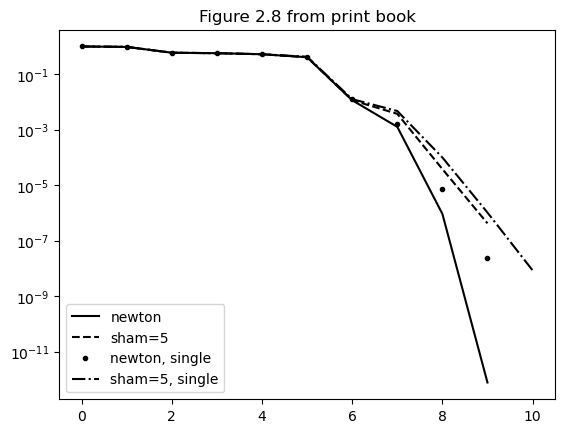

In [12]:
bvpoutn64=bvptest(U0, FV, FPV, bdata;  bsham=1);
bvpouts64=bvptest(U0, FV, FPV, bdata; bsham=5);
bvpoutn32=bvptest(U0, FV, FPV32, bdata;  bsham=1);
bvpouts32=bvptest(U0, FV, FPV32, bdata; bsham=5);
newtonhist=bvpoutn64.history./bvpoutn64.history[1];
shamhist=bvpouts64.history./bvpoutn64.history[1];
newtonhist32=bvpoutn32.history./bvpoutn64.history[1];
shamhist32=bvpouts32.history./bvpoutn64.history[1];
nn=length(newtonhist);
ns=length(shamhist);
nn32=length(newtonhist32);
ns32=length(shamhist32);
semilogy(0:nn-1,newtonhist,"k-",0:ns-1,shamhist,"k--",
    0:nn32-1,newtonhist32,"k.",0:ns32-1,shamhist32,"k-.")
legend(["newton","sham=5","newton, single",
        "sham=5, single"]);
title("Figure 2.8 from print book");


We now query the iteration statistics to see what the line search did for
Newton's method in double precision. We see that the line search
was active in the middle of the iteration.

In [13]:
bvpoutn64.stats.iarm'

1×10 adjoint(::Vector{Int64}) with eltype Int64:
 0  0  0  2  2  1  0  0  0  0

Updating the Jacobian less frequently has a smaller impact than in the case of the H-equation. You should expect this because the linear solver costs $O(N)$ work rather than $O(N^3)$ and the Jacobian is updated for the early iterations because the residual is not decreasing fast enough.

The other interesting feature of this computation is that the single precision results differ in a meaningful way from the double precision results. The reason for this is that the Jacobian is ill-conditioned enough to affect the quality of the single precision solver. The condition number of the Jacobian is $O(N)$, so for $N=10^5$ one should expect different results from the linear solve in single precision, and that's what you get.

Moreover, the benchmark results say that there is no benefit from doing the linear algebra in single precision. This is also no surprise since the factorization is $O(N)$ work.

The reader should try this problem with $N=10^6$ and watch the line search fail for the single precision linear algebra computations. That is also no surprise with an inaccurate Newton direction.

In [14]:
println("analytic, double, Newton"); 
@btime bvptest($U0, $FV, $FPV, $bdata;  bsham=1);
println("analytic, double, sham=5"); 
@btime bvptest($U0, $FV, $FPV, $bdata;  bsham=5);
println("analytic, single, Newton"); 
@btime bvptest($U0, $FV, $FPV32, $bdata;  bsham=1);
println("analytic, single, sham=5"); 
@btime bvptest($U0, $FV, $FPV32, $bdata;  bsham=5);

analytic, double, Newton
  89.220 ms (144 allocations: 47.47 MiB)
analytic, double, sham=5
  76.740 ms (136 allocations: 44.41 MiB)
analytic, single, Newton
  85.078 ms (198 allocations: 54.79 MiB)
analytic, single, sham=5
  77.907 ms (203 allocations: 57.85 MiB)


### Section 2.8.4: Shamanskii for the Convection-Diffusion Problem

The dominant cost in the solution of the PDE problem is the computation and factorization of the sparse Jacobian. Even for the small problem with $31^2 = 961$ unknowns, one can see the effects. We will compare a Newton iteration with the default strategy using ```@btime```. The code that generated the results in section 2.7.5 contained the initialization. It's important to separate that from the solver if you're doing benchmarking. So we will set up the problem first and then benchmark the solver phase.

In [15]:
n=31;
# Get some room for the residual
u0=zeros(n*n);
FV=copy(u0);
# Get the precomputed data from pdeinit
pdata=pdeinit(n)
# Storage for the Jacobian, 
# same sparsity pattern as the discrete Laplacian
J=copy(pdata.D2);
println("Newton"); 
@btime nsol(pdeF!, u0, FV, J, pdeJ!; 
    resdec=.5, rtol=1.e-7, atol=1.e-10, 
    pdata=pdata, sham=1);
println("sham=5"); 
@btime nsol(pdeF!, u0, FV, J, pdeJ!; 
    resdec=.5, rtol=1.e-7, atol=1.e-10, 
    pdata=pdata, sham=5);

Newton
  5.616 ms (823 allocations: 10.82 MiB)
sham=5
  3.876 ms (586 allocations: 7.29 MiB)


The Shamanskii iteration, which forms and factors the Jacobian only twice, saves about 40% in time. This is a larger savings than we saw with the two-point boundary value problem, but far from dramatic. The __SuiteSparse__ solvers are very good. The reader should try the same test with a finer mesh to see if the results change. 

### Section 2.8.5: ptcsol.jl

__ptcsol.jl__ is our $\ptc$ solve. As usual, we begin with the docstrings ...

In [16]:
?ptcsol

search: ptcsol ptcsoli ptcsolsc nsol cool htol aasol



ptcsol(F!, x0, FS, FPS, J! = diffjac!; rtol=1.e-6, atol=1.e-12,              maxit=20, delta0=1.e-6, dx=1.e-7, pdata = nothing, jfact = klfact,                printerr = true, keepsolhist = false, jknowsdt = false)

C. T. Kelley, 2022

Julia versions of the nonlinear solvers from my SIAM books.  Herewith: some new stuff ==> ptcsol

PTC finds the steady-state solution of u' = -F(u), u(0) = u_0. The - sign is a convention.

You must allocate storage for the function and Jacobian in advance –> in the calling program <– ie. in FS and FPS

Inputs:

  * F!: function evaluation, the ! indicates that F! overwrites FS, your   preallocated storage for the function.

    So, FS=F!(FS,x) or FS=F!(FS,x,pdata) returns FS=F(x)

    Your function MUST have –> return FS <– at the end.   See the examples in the TestProblems/Systems/FBeam!.jl
  * x0: initial iterate

  * FS: Preallocated storage for function. It is a vector of size N

    You should store it as (N) and design F! to use vectors of size (N). If you use (N,1) consistently instead, the solvers may work, but I make no guarantees.
  * FPS: preallocated storage for Jacobian. It is an N x N matrix

    If FPS is sparse, you **must** allocate storage for the diagonal so I will have room to put 1/dt in there.
  * J!: Jacobian evaluation, the ! indicates that J! overwrites FPS, your   preallocated storage for the Jacobian. If you leave this out the   default is a finite difference Jacobian.

    So, FP=J!(FP,FS,x) or FP=J!(FP,FS,x,pdata) returns FP=F'(x);   (FP,FS, x) must be the argument list, even if FP does not need FS.   One reason for this is that the finite-difference Jacobian   does and that is the default in the solver.

    Your Jacobian function MUST have –> return FP <– at the end.    See the examples in the TestProblems/Systems/FBeam!.jl

    You may have a better way to add (1/dt) I to your Jacobian. If you   want to do this yourself then your Jacobian function should be   FP=J!(FP,FS,x,dt) or FP=J!(FP,FS,x,dt,pdata) and return   F'(x) + (1.0/dt)*I. 

    You will also have to set the kwarg **jknowsdt** to true.
  * Precision: Lemme tell ya 'bout precision. I designed this code for    full precision   functions and linear algebra in any precision you want. You can declare   FPS as Float64, Float32, or Float16 and ptcsol will do the right thing if   YOU do not destroy the declaration in your J! function. I'm amazed   that this works so easily. If the Jacobian is reasonably well   conditioned, you can cut the cost of Jacobian factorization and   storage in half with no loss. For large dense Jacobians and inexpensive   functions, this is a good deal.

    BUT ... There is very limited support for direct sparse solvers in   anything other than Float64. I recommend that you only use Float64   with direct sparse solvers unless you really know what you're doing. I   have a couple examples in the notebook, but watch out.

---

Keyword Arguments (kwargs):

rtol and atol: relative and absolute error tolerances

delta0: initial pseudo time step. The default value of 1.e-3 is a bit conservative and is one option you really should play with. Look at the example where I set it to 1.0!

maxit: limit on nonlinear iterations, default=100. 

This is coupled to delta0. If your choice of delta0 is too small (conservative) then you'll need many iterations to converge and will need a larger value of maxit

For PTC you'll need more iterations than for a straight-up nonlinear solve. This is part of the price for finding the  stable solution.

dx: default = 1.e-7

difference increment in finite-difference derivatives       h=dx*norm(x)+1.e-6

pdata:

precomputed data for the function/Jacobian.  Things will go better if you use this rather than hide the data  in global variables within the module for your function/Jacobian

jfact: default = klfact (tries to figure out best choice) 

If your Jacobian has any special structure, please set jfact to the correct choice for a factorization.

I use jfact when I call PTCUpdate to evaluate the Jacobian (using your J!) and factor it. The default is to use klfact (an internal function) to do something reasonable. For general dense matrices, klfact picks lu! to compute an LU factorization and share storage with the Jacobian.  You may change LU to something else by, for example, setting jfact = cholseky! if your Jacobian is spd.

klfact knows about banded matrices and picks qr. You should, however RTFM, allocate the extra two upper bands, and use jfact=qr! to override klfact.

klfact uses lu for general sparse matrices.

If you give me something that klfact does not know how to dispatch on, then nothing happens. I just return the original Jacobian matrix and  ptcsol will use backslash to compute the Newton step.

I know that this is probably not optimal in your situation, so it is  good to pick something else, like jfact = lu.

printerr: default = true

I print a helpful message when the solver fails. To suppress that message set printerr to false.

keepsolhist: default = false

Set this to true to get the history of the iteration in the output tuple. This is on by default for scalar equations and off for systems. Only turn it on if you have use for the data, which can get REALLY LARGE.

jknowsdt: default = false

Set this to true if your Jacobian evaluation function returns F'(x) + (1/dt) I. You'll also need to follow the rules above for the Jacobian evaluation function. I do not recommend this and if your Jacobian is anything other than a matrix I can't promise anything. I've tested this for matrix outputs only.

Output:

A named tuple (solution, functionval, history, stats, idid,                errcode, solhist) where

solution = converged result functionval = F(solution) history = the vector of residual norms (||F(x)||) for the iteration

Unlike nsol, nsoli, or even ptcsoli, ptcsol has a fixed cost per  iteration of one function, one Jacobian, and one Factorization. Hence iteration statistics are not interesting and not in the output. 

idid=true if the iteration succeeded and false if not.

errcode = 0 if the iteration succeeded         = -1 if the initial iterate satisfies the termination criteria         = 10 if no convergence after maxit iterations

solhist:

This is the entire history of the iteration if you've set keepsolhist=true

solhist is an N x K array where N is the length of x and K is the number of iteration + 1. So, for scalar equations, it's a row vector.

### Example for ptcsol

#### The buckling beam problem.

You'll need to use TestProblems for this to work.

```jldoctest
julia> using SIAMFANLEquations.TestProblems

julia> n=63; maxit=1000; delta = 0.01; lambda = 20.0;

julia> bdata = beaminit(n, 0.0, lambda); x = bdata.x;

julia> u0 = x .* (1.0 .- x) .* (2.0 .- x);

julia> u0 .*= exp.(-10.0 * u0);

julia> FS = copy(u0); FPS = copy(bdata.D2);

julia> pout = ptcsol( FBeam!, u0, FS, FPS, BeamJ!; 
 rtol = 1.e-10, pdata = bdata, delta0 = delta, maxit = maxit);

julia> # It takes a few iterations to get there.
       length(pout.history)
25

julia> [pout.history[1:5] pout.history[21:25]]
5×2 Array{Float64,2}:
 6.31230e+01  9.75412e-01
 7.52624e+00  8.35295e-02
 8.31545e+00  6.58797e-04
 3.15455e+01  4.12697e-08
 3.66566e+01  6.29295e-12

julia> # We get the nonnegative steady state.
       maximum(pout.solution)
2.19086e+00
```


#### More on the Buckling Beam

The residual function for the beam uses precomputed data to store the discrete second derivative and the bifurcation parameter $\lambda$. These data are smaller and far less complex that the data for the H-equation and it's worthwhile to look at the functions. These are part of the __TestProblems__ submodule for __SIAMFANLEquations.jl__. We will not cover all the details here, but will give you enough to see how precomputed data is useful. The file is __TestProblems/Systems/FBeam!.jl__.

First the function itself
```Julia
"""
FBeam!(FV, U, bdata)
Function evaluation for PTC example.
F(u) = -u'' - lambda sin(u)
"""
function FBeam!(FV, U, bdata)
    D2 = bdata.D2
    lambda = bdata.lambda
    su = lambda * sin.(U)
    FV .= (D2 * U - su)
end
```
Note how the function ```FBeam``` harvests $\lambda$ and the discrete second derivative ```D2``` from the precomputed data ```bdata```. In this case ```bdata``` is a __named tuple__ which we create with the
__beaminit__ function.

```Julia
"""
beaminit(n,dt,lambda=20.0)

Set up the beam problem with n interior grid points.
"""

function beaminit(n, dt, lambda = 20.0)
    D2 = Lap1d(n)
    dx = 1.0 / (n + 1)
    x = collect(dx:dx:1.0-dx)
    UN = zeros(size(x))
    bdata = (D2 = D2, x = x, dx = dx, dt = dt, 
             lambda = lambda, UN = UN)
end
```
The bdata structure has more that just ```D2``` and $\lambda$. There are also data for the solver and the construction of the Jacobian.

Finally, the function __Lap1D__ computes ```D2``` as a tridiagonal matrix. This is part of the LinearAlgebra package that is part of Julia.Base.

```Julia
"""
Lap1d(n)

returns -d^2/dx^2 on [0,1] zero BC
"""
function Lap1d(n)
    dx = 1 / (n + 1)
    d = 2.0 * ones(n)
    sup = -ones(n - 1)
    slo = -ones(n - 1)
    D2 = Tridiagonal(slo, d, sup)
    D2 = D2 / (dx * dx)
    return D2
end

```



## Section 2.9: Projects

### More on the H-equation

- Run the H-equation tests with $c=.99$ and larger dimensions ($2^k$ for $k=12, 13, 14$). Are the values of ```sham``` and ```resdec``` optimal for this case? How, for example, is ```resdec = Inf``` (your author's favorite value). To see why I like ```sham=Inf``` have a look at
<cite data-cite="brent"><a href="siamfa.html#brent">(Bre73)</cite>.

- What happens with $c=1$? Is the chord method a good idea? 
Don't look at
<cite data-cite="ctk:sirev20"><a href="siamfa.html#ctk:sirev20">(Kel22)</cite>,
<cite data-cite="ctk:n1"><a href="siamfa.html#ctk:n1">(DK80)</cite>, or
<cite data-cite="ctk:chord"><a href="siamfa.html#ctk:chord">(DK83)</cite> before trying to figure things out on your own.

- Increase the dimension as much as you can and compare single and double precision linear algebra.
    
- Duplicate the table on page 125 of <cite data-cite="chand"><a href="siamfa.html#chand">(Cha60)</cite>.    


### Automatic Differentiation

__(Not trivial!)__ Try using __automatic differentiation__ to compute the Jacobian for the examples in this chapter and use the results to write a Jacobian evaluation function to pass to __nsol.jl__.
You will first have to decide how you want to do that. Two mature packages are [ForwardDiff.jl](#https://github.com/JuliaDiff/ForwardDiff.jl)
<cite data-cite="forwarddiff"><a href="siamfa.html#forwarddiff">(RPL16)</cite>
and [Zygote.jl](#https://github.com/FluxML/Zygote.jl) 
<cite data-cite="zygote"><a href="siamfa.html#zygote">(CoRR)</cite>.
Books like
<cite data-cite="grautodiff"><a href="siamfa.html#grautodiff">(Gri00)</cite> explain the
algorithmic differences between these packages.
    
How does the performance compare to an analytic or forward difference Jacobian? 

### Nested Iteration

Solving a differential or integral equation
by __nested iteration__ or __grid sequencing__ means resolving
the rough features of the solution of a differential or
integral equation on a coarse mesh, interpolating the
solution to a finer mesh, resolving on the finer mesh, and
then repeating the process until you have a solution on a target
mesh.

Apply this idea to some of the examples in the text, using piecewise
linear interpolation to move from coarse to fine meshes. If the
discretization is second-order accurate and you halve the mesh
width at each level, how should you terminate the solver at
each level? What kind of iteration statistics would tell you that
you've done a satisfactory job?


### Sparse Differencing

Write Jacobian evaluation functions using sparse differencing for the boundary value problem and the buckling beam examples. You can try, for example, the methods from 
<cite data-cite="curtispr"><a href="siamfa.html#curtisor">(CPR74)</cite> or
<cite data-cite="colmore"><a href="siamfa.html#colmore">(CM83)</cite>.  <cite data-cite="ctk:newton"><a href="siamfa.html#ctk:newton">(Kel03)</cite> has a Matlab code for banded matrices that, while convertible to Julia, needs some work to explicitly store the Jacobian as a BandedMatrix so
[BandedMatrices.jl](https://github.com/JuliaMatrices/BandedMatrices.jl) will solve the linear system efficiently.
Another alternative is to use __sparsefdiff__ 
<cite data-cite="sparsediff"><a href="siamfa.html#sparsediff">(RMGH20)</cite> from
[SparseDiffTools.jl](#https://github.com/JuliaDiff/SparseDiffTools.jl). 
    
No matter what you do, you'll need to think about fill-in, symbolic factorization in the general case, and storage. 
    
Have fun!    

###  ```lu!``` for Sparse Matrices

This project is for Julia 1.5 and higher. The option ```jfact=nofact``` in __nsol.jl__ is there so you can build and manage your own factorization inside your Jacobian evaluation function. Use this feature to store a factorization of the Jacobian for the PDE problem and reuse that storage rather than reallocating with every call to lu. What are the savings in time and allocations? You'll need to figure out how to use ```lu!``` for sparse matrices to do this project.

### How does $\delta_0$ depend on $\delta_x$?

Vary $\delta_x$ and $\delta_0$ in the buckling beam example. For 
the fixed $\delta_x = 1/64$ in the example, explore the effects of
increasing $\delta_0$. Can you converge to the ``wrong'' (\ie negative)
solution in this way? What happens if you fix $\delta_0$ and reduce
$\delta_x$?

## Next notebook = [Chapter 3: Newton-Krylov Methods](SIAMFANLCh3.ipynb)